In [4]:
import pandas as pd
import seaborn as sns

In [6]:
aaa = pd.read_csv('../BoolODE/simulations/simulations/E0.csv').melt('Unnamed: 0')
aaa['variable'] = aaa.variable.str.lstrip('E0_').astype(int)

In [19]:
def simulateAndSample(argdict):
    allParameters = argdict['allParameters']
    parNames = argdict['parNames']
    Model = argdict['Model']
    isStochastic = argdict['isStochastic']
    tspan = argdict['tspan']
    varmapper = argdict['varmapper']
    timeIndex = argdict['timeIndex']
    genelist = argdict['genelist']
    proteinlist = argdict['proteinlist']
    writeProtein=argdict['writeProtein']
    cellid = argdict['cellid']
    outPrefix = argdict['outPrefix']
    sampleCells = argdict['sampleCells']
    ss = argdict['ss']
    ModelSpec = argdict['ModelSpec']
    rnaIndex = argdict['rnaIndex']
    proteinIndex = argdict['proteinIndex']
    genelist = argdict['genelist']
    proteinlist = argdict['proteinlist']
    revvarmapper = argdict['revvarmapper']
    seed = argdict['seed']
    pars = argdict['pars']
    x_max = argdict['x_max']
    if sampleCells:
        header = argdict['header']
    pars = {}
    for k, v in allParameters.items():
        pars[k] = v
    pars = [pars[k] for k in parNames]
    
    ## Boolean to check if a simulation is going to a
    ## 0 steady state, with all genes/proteins dying out
    retry = True
    trys = 0
    
    ## timepoints
    tps = [i for i in range(1,len(tspan))]
    ## gene ids
    gid = [i for i,n in varmapper.items() if 'x_' in n]
    outPrefix = outPrefix +'simulations/'
    while retry:
        seed += 1000
        y0_exp = getInitialCondition(ss, ModelSpec, rnaIndex, proteinIndex,
                                     genelist, proteinlist,
                                     varmapper,revvarmapper)
        
        P = simulateModel(Model, y0_exp, pars, isStochastic, tspan, seed)
        P = P.T
        retry = False
        ## Extract Time points
        subset = P[gid,:][:,tps]
        df = pd.DataFrame(subset,
                          index=pd.Index(genelist),
                          columns = ['E' + str(cellid) +'_' +str(i)\
                                     for i in tps])
        ## Heuristic:
        ## If the largest value of a protein achieved in a simulation is
        ## less than 10% of the y_max, drop the simulation.
        ## This check stems from the observation that in some simulations,
        ## all genes go to the 0 steady state in some rare simulations.
        dfmax = df.max()
        for col in df.columns:
            colmax = df[col].max()
            if colmax < 0.1*x_max:
                retry= True
                break
        
        if sampleCells:
            ## Write a single cell to file
            ## These samples allow for quickly and
            ## reproducibly testing the output.
            sampledf = utils.sampleCellFromTraj(cellid,
                                          tspan, 
                                          P,
                                          varmapper, timeIndex,
                                          genelist, proteinlist,
                                          header,
                                          writeProtein=writeProtein)
            sampledf = sampledf.T
            sampledf.to_csv(outPrefix + 'E' + str(cellid) + '-cell.csv')            
            
        trys += 1
        if trys > 1:
            print('try', trys)
            

    # write to file
    df.to_csv(outPrefix + 'E'+ str(cellid) + '.csv')aa

,Unnamed: 0,variable,value
0,g2,1,0.101001
1,g6,1,0.008745
2,g1,1,1.069955
3,g8,1,0.208025
4,g7,1,0.014953
...,...,...,...
13988,g1,1999,0.001006
13989,g8,1999,1.996858
13990,g7,1999,0.034544
13991,g3,1999,0.026100


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0        g2
1        g6
2        g1
3        g8
4        g7
         ..
13988    g1
13989    g8
13990    g7
13991    g3
13992    g4
Name: Unnamed: 0, Length: 13993, dtype: object

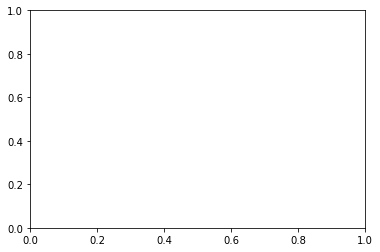

In [18]:
sns.scatterplot(x = aaa.variable, y = aaa.value, c = aaa['Unnamed: 0'])